# Νευρωνικά Δίκτυα

Παρακάτω θα παρουσιάσουμε μερικές αρχιτεκτονικές νευρωνικών δικτύων.

***

## Συναρτήσεις 

Οι παρακάτω βοηθητικές συναρτήσεις θα χρησιμοποιηθούν για να κάνουμε train και test το μοντέλο.

Αρχικά κάνουμε τα απαραίτητα imports και ορίζουμε την συσκευή που θα χρησιμοποιήσουμε (cpu/gpu).

In [1]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import pandas as pd
import os
from torch.optim import lr_scheduler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from pathlib import Path

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device, imports complete!'.format(device))

Using cuda device, imports complete!


Στην συνέχεια ορίζουμε την πρώτη συνάρτηση η οποία δέχεται ένα μοντέλο, το training dataset, την συνάρτηση λάθους, τον optimizer, και την συσκευή που χρησιμοποιούμε. Προχωράει το training κατά ένα βήμα και επιστρέφει την απώλεια.

In [2]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = 'cpu'):
    model.to(device)
    model.train()

    train_loss = 0
    for X_batch, y_batch in data_loader:
        # Send data to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent gradients exploding
        optimizer.step()

        train_loss += loss.item()
    
    return train_loss


Ομοίως η παρακάτω συνάρτηση κάνει test το μοντέλο σε κάθε εποχή, και επιστρέφει την απώλεια.

In [3]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = 'cpu'):
    model.to(device)
    model.eval()

    test_loss = 0
    with torch.inference_mode():
        for X_batch, y_batch in data_loader:
            # Send data to GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_test_pred = model(X_batch)
            test_loss += loss_fn(y_test_pred, y_batch).item()
    
    return test_loss

Η βασική συνάρτηση, επαναληπτικά για όσες εποχές έχουμε διαλέξει κάνει train και test το μοντέλο, και ανά 10 εποχές εκτυπώνει τα αποτελέσματα. Επιστρέφει 2 πίνακες με τις συνολικές απώλειες σε κάθε επανάληψη.

In [4]:
def train_test_model(epoch : int, 
                     model: torch.nn.Module,
                     train_loader: torch.utils.data.DataLoader,
                     test_loader: torch.utils.data.DataLoader,
                     loss_fn: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     scheduler,
                     device: torch.device = 'cpu'):
    torch.manual_seed(42)
    train_loss_arr = []
    test_loss_arr = []
    for epochs in range(epoch):
        epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
        train_loss_arr.append(epoch_loss / len(train_loader))

        scheduler.step(epoch_loss)
        after_lr = optimizer.param_groups[0]['lr']

        test_loss = test_step(model, test_loader, loss_fn, device)
        test_loss_arr.append(test_loss / len(test_loader))

        if (epochs) % 10 == 0 or epochs == 0:
            print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')
        elif epochs + 1 == epoch:
            print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')
    
    return train_loss_arr, test_loss_arr

Η συνάρτηση είναι παρόμοια με την test_step με την διαφορά ότι επιστρέφει ένα dictionary με τα βασικά στοιχεία του μοντέλου.

In [5]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               scaler,
               device: torch.device = 'cpu'):

    model.eval()
    all_preds = []
    all_targets = []

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            # Move to CPU and collect all predictions and targets
            all_preds.append(y_pred.cpu())
            all_targets.append(y.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Reverse scaling
    y_pred_real = scaler.inverse_transform(all_preds)
    y_true_real = scaler.inverse_transform(all_targets)

    # Calculate average Euclidean distance (in cm)
    distances = np.linalg.norm(y_pred_real - y_true_real, axis=1)
    mean_distance_error = np.mean(distances)
    std_distance_error = np.std(distances)

    return {
        "model_name": model.__class__.__name__,
        "mean_distance_error_cm": mean_distance_error.item(),
        "std" : std_distance_error.item()
    }


Η συνάρτηση αυτή χρησιμοποιείται για να εμφανίσει τις κανονικοποιημένες στο (0,1) train_loss και test_loss curves.

In [6]:
def plot_results(train_arr, test_arr):
    # Plot the loss curves
    train_arr = (train_arr - np.min(train_arr)) / (np.max(train_arr) - np.min(train_arr))
    test_arr = (test_arr - np.min(test_arr)) / (np.max(test_arr) - np.min(test_arr))
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_arr, label='Train Loss')
    plt.plot(test_arr, label='Test Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Normalized Loss")
    plt.title("Normalized Training Loss")
    plt.grid()
    plt.legend()
    plt.show()

***

## Εισαγωγή δεδομένων

Η συνάρτηση αυτή δέχεται τα paths των δεδομένων, δημιουργεί και επιστρέφει τα mini_batches που θα χρησιμοποιηθούν στο training.

Κάνουμε scale και το Y οπότε σε περίπτωση τυχαίου διανύσματος θα πρέπει να το κάνουμε και αυτό scale, και μετά το output να το επαναφέρουμε.

In [7]:
def data_func(input_array, labels, batch_size = 32, test_size = 0.2):
    # Reshape the tensor to 2D so that it can be used in the linear model
    X = input_array.reshape(len(input_array), -1)
    y = labels[:,:2]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    scaler_X = StandardScaler()
    # Fit the scaler_X on the training data and transform both the training and test sets
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_Y = StandardScaler()
    # Also scale the Y input since when we use MSE loss and the labels are in CM, MSE will scale quadratically with those values
    y_train = scaler_Y.fit_transform(y_train)
    y_test = scaler_Y.transform(y_test)

    # Transform the data to PyTorch tensors and move them to the GPU if available
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Define the dataset
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    # Define the data loader
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y

Ανάλογα με τον ποιον φάκελο θέλουμε να διαβάσουμε αλλάζουμε το νουμεράκι.

In [8]:
# Get the directory of the script
parent_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()

parent_dir = os.path.join(parent_dir, '..', 'Experiments', 'Raw_Data_1') 


rfid_label = np.load(f"{parent_dir}\\final_labels.npy")
info_tensor = np.load(f"{parent_dir}\\final_tensor.npy")

rfid_label = rfid_label[:,:2]

info_tensor.shape , rfid_label.shape

((1013, 500, 4), (1013, 2))

Ουσιαστικά αναζητούμε τα **Χ και Υ** του RFID TAG, γνωρίζοντας το πως **κινήθηκε** και την μέτρηση της **φάσης** του.

In [9]:
train_loader, test_loader, scaler_rev= data_func(info_tensor, rfid_label)

In [10]:
len(train_loader) # Should be (total_tags / batch_size) * train_partition rounded to the upper integer

26

Αποθηκεύουμε σε μεταβλητές τα μεγέθη του input και του output για τα γραμμικά μοντέλα.

In [11]:
output_len = rfid_label.shape[1]
input_len = info_tensor.shape[1] * info_tensor.shape[2]

input_len,output_len

(2000, 2)

***

## Αρχιτεκτονικές

### Αρχιτεκτονική 1

Το πρώτο μας μοντέλο θα είναι η απλούστερη περίπτωση ενός γραμμικού layer με είσοδο το ```input_size``` δηλαδή 4000 (για την ώρα) , και έξοδο 2 (x,y), χωρίς για αρχή κάποια συνάρτηση ενεργοποίησης.

Σαν συνάρτηση λάθους θα χρησιμοποιηθεί η ```MSELoss``` ενώ σαν optimizers θα δοκιμαστούν οι ```Adam```, ```RMSProp```, ```SGD```.

In [12]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= output_size),  
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 18.740139814523552 | Loss test: 1.7047147069658553 | lr = 0.01
Epoch 10 | Loss train: 2.3231795040460734 | Loss test: 3.0045450074332103 | lr = 0.01
Epoch 20 | Loss train: 1.817579863163141 | Loss test: 2.0759091632706776 | lr = 0.01
Epoch 30 | Loss train: 1.570857449219777 | Loss test: 1.8457872186388289 | lr = 0.01
Epoch 40 | Loss train: 0.3758917754659286 | Loss test: 0.4848745231117521 | lr = 0.001
Epoch 50 | Loss train: 0.2839420231489035 | Loss test: 0.472907902938979 | lr = 0.0001
Epoch 60 | Loss train: 0.27972453803970265 | Loss test: 0.4722076398985727 | lr = 0.0001
Epoch 70 | Loss train: 0.2767689743867287 | Loss test: 0.47394685660089764 | lr = 0.0001
Epoch 80 | Loss train: 0.27502726648862547 | Loss test: 0.4776747886623655 | lr = 1e-05
Epoch 90 | Loss train: 0.26495681044000846 | Loss test: 0.4747913713966097 | lr = 1e-05
Epoch 100 | Loss train: 0.26527000218629837 | Loss test: 0.4760923023734774 | lr = 1e-05


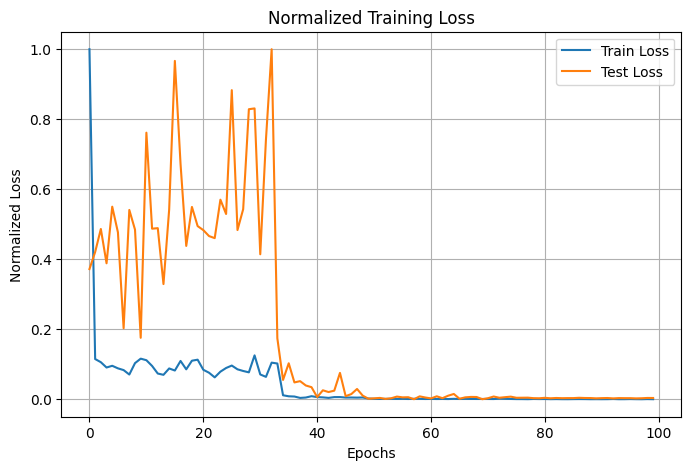

In [13]:
# Instantiate the model
model_0 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 100,model = model_0, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

Χρησιμοποιήσαμε τον optimizer ``` Adam ``` τώρα θα χρησιμοποιήσουμε τον ``` RMSProp```

Epoch 0 | Loss train: 816.3366360710218 | Loss test: 105.97552980695453 | lr = 0.01
Epoch 10 | Loss train: 36.06554838327261 | Loss test: 28.14954158238002 | lr = 0.01
Epoch 20 | Loss train: 33.392896982339714 | Loss test: 21.338354110717773 | lr = 0.01
Epoch 30 | Loss train: 32.13605242509108 | Loss test: 34.806104932512554 | lr = 0.01
Epoch 40 | Loss train: 0.7197049065278127 | Loss test: 1.0590303114482336 | lr = 0.001
Epoch 50 | Loss train: 0.6608888885149589 | Loss test: 0.8819657649312701 | lr = 0.001
Epoch 60 | Loss train: 0.64457457111432 | Loss test: 0.6653983422688076 | lr = 0.001
Epoch 70 | Loss train: 0.30982645887594956 | Loss test: 0.48391054357801166 | lr = 0.0001
Epoch 80 | Loss train: 0.29809640691830563 | Loss test: 0.46858154237270355 | lr = 1e-05
Epoch 90 | Loss train: 0.28655266389250755 | Loss test: 0.4765601945774896 | lr = 1e-05
Epoch 100 | Loss train: 0.2883638395712926 | Loss test: 0.4698274944509779 | lr = 1e-05


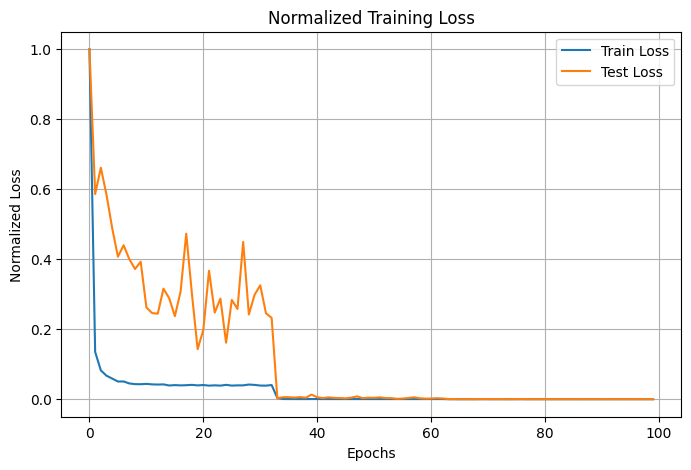

In [14]:
# Instantiate the model
model_1 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(model_1.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 100,model = model_1, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

Και τέλος χρησιμοποιούμε και τον ``` SGD ```

Epoch 0 | Loss train: 0.5600914754546605 | Loss test: 0.49532643386295866 | lr = 0.01
Epoch 10 | Loss train: 0.5192715319303366 | Loss test: 0.5457872854811805 | lr = 0.01
Epoch 20 | Loss train: 0.5188674382292308 | Loss test: 0.6588316900389535 | lr = 0.01
Epoch 30 | Loss train: 0.3070507829005902 | Loss test: 0.513800608260291 | lr = 0.001
Epoch 40 | Loss train: 0.3152869140299467 | Loss test: 0.47491341829299927 | lr = 0.001
Epoch 50 | Loss train: 0.30203347681806636 | Loss test: 0.4731347816331046 | lr = 0.001
Epoch 60 | Loss train: 0.2906257470066731 | Loss test: 0.47707837181431906 | lr = 0.0001
Epoch 70 | Loss train: 0.2890722636993115 | Loss test: 0.47506374972207205 | lr = 0.0001
Epoch 80 | Loss train: 0.2938346484532723 | Loss test: 0.47552614552634104 | lr = 0.0001
Epoch 90 | Loss train: 0.2804829120062865 | Loss test: 0.4728522322007588 | lr = 1e-05
Epoch 100 | Loss train: 0.28180942512475526 | Loss test: 0.4707183539867401 | lr = 1e-05


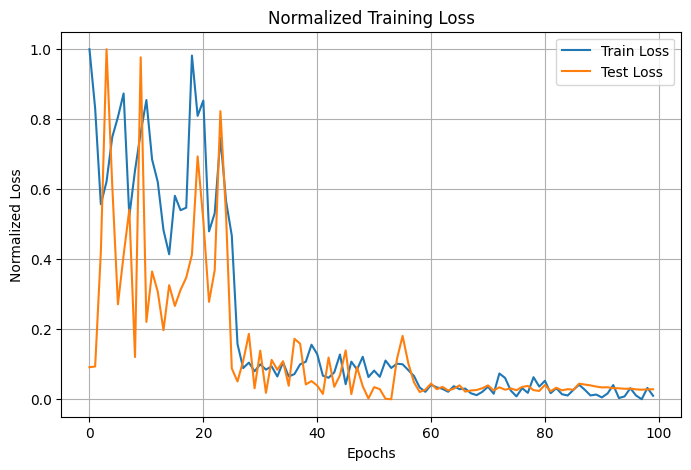

In [15]:
# Instantiate the model
model_2 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=learning_rate, momentum= 0.9)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 100,model = model_2, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

Έχοντας προπονήσει τα μοντέλα για 100 εποχές με διαφορετικούς optimizers παρατηρούμε ότι η καλύτερη απόδοση έιναι από τον ``` Adam ``` ο οποίος θα χρησιμοποιηθεί και μετέπειτα.

***

### Αρχιτεκτονική 2

#### ReLU 128

Το δεύτερο μοντέλο μας θα αποκτήσει άλλα 2 layers δίνοντας μας την δυνατότητα θεωρητικά να πετύχουμε μικρότερη απώλεια συγκριτικά με την απλούστερη περίπτωση. Επιπλέον μας δίνεται η δυνατότητα να μεταβάλλουμε τόσο την μεταβλητή ```hidden_units``` που καθορίζει το μέγεθος των ενδιάμεσων επιπέδων, όσο και τις συναρτήσεις ενεργοποίησης.

Για αρχή επιλέγουμε την συνηθέστερη επιλογή την συνάρτηση ``` ReLU```, ο τύπος της οποίας δίνεται παρακάτω.

$ReLU(x) = max(0,x)$

In [16]:
# Build the model

class ReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(ReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 18.290533998837837 | Loss test: 0.8237151418413434 | lr = 0.01
Epoch 10 | Loss train: 0.4487291081593587 | Loss test: 0.509653606585094 | lr = 0.01
Epoch 20 | Loss train: 0.3971260625582475 | Loss test: 0.4790642708539963 | lr = 0.01
Epoch 30 | Loss train: 0.3275984671826546 | Loss test: 0.4638995996543339 | lr = 0.01
Epoch 40 | Loss train: 0.2710388738375444 | Loss test: 0.40593800055129187 | lr = 0.01
Epoch 50 | Loss train: 0.2461725204036786 | Loss test: 0.41329655264105114 | lr = 0.01
Epoch 60 | Loss train: 0.23616566594976646 | Loss test: 0.43367318383284975 | lr = 0.01
Epoch 70 | Loss train: 0.15002289614998376 | Loss test: 0.3885111542684691 | lr = 0.001
Epoch 80 | Loss train: 0.1357184608395283 | Loss test: 0.3930389540536063 | lr = 0.001
Epoch 90 | Loss train: 0.13228398676101977 | Loss test: 0.42397639794009073 | lr = 0.001
Epoch 100 | Loss train: 0.12140506076124999 | Loss test: 0.4113029454435621 | lr = 0.001


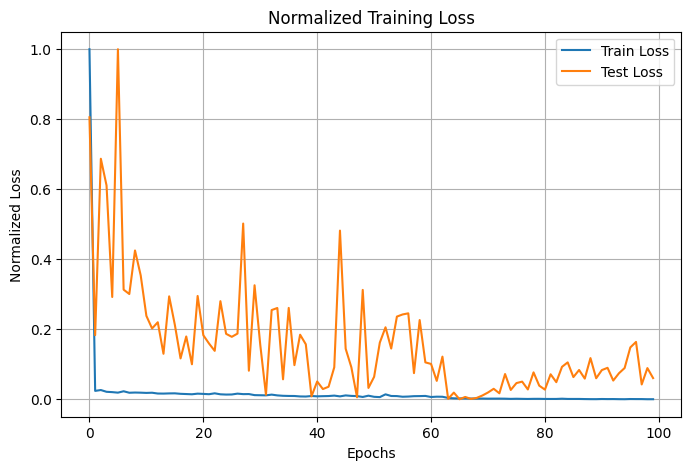

In [17]:
# Instantiate the model
model_3 = ReLUModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 100,model = model_3, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

relu_model = eval_model(model_3, test_loader, scaler_rev, device)

In [18]:
relu_model

{'model_name': 'ReLUModel',
 'mean_distance_error_cm': 21.660932540893555,
 'std': 21.328611373901367}

Ήδη τα αποτελέσματα είναι πολύ καλύτερα συγκριτικά με την προηγούμενη αρχιτεκτονική. **NOT**

#### ReLU 256

Τώρα θα αυξήσουμε τον αριθμό των ```hidden_units```  από 128 σε 256 για να δούμε κάποια πιθανή διαφορά.

Epoch 0 | Loss train: 76.77786904688065 | Loss test: 0.6790448682648795 | lr = 0.01
Epoch 10 | Loss train: 0.5225320103076788 | Loss test: 0.5548062473535538 | lr = 0.01
Epoch 20 | Loss train: 0.5262183019748101 | Loss test: 0.5032235234975815 | lr = 0.01
Epoch 30 | Loss train: 0.4546338594876803 | Loss test: 0.6616415892328534 | lr = 0.01
Epoch 40 | Loss train: 0.38699990740189183 | Loss test: 0.5622120840208871 | lr = 0.01
Epoch 50 | Loss train: 0.34510031227882093 | Loss test: 0.45543635317257475 | lr = 0.01
Epoch 60 | Loss train: 0.3202414489709414 | Loss test: 0.4692989545209067 | lr = 0.01
Epoch 70 | Loss train: 0.27046315429302364 | Loss test: 0.4433721261365073 | lr = 0.01
Epoch 80 | Loss train: 0.26692939492372364 | Loss test: 0.40974186680146624 | lr = 0.01
Epoch 90 | Loss train: 0.1612612043435757 | Loss test: 0.40591754338571 | lr = 0.001
Epoch 100 | Loss train: 0.1359034995906628 | Loss test: 0.38786619156599045 | lr = 0.001


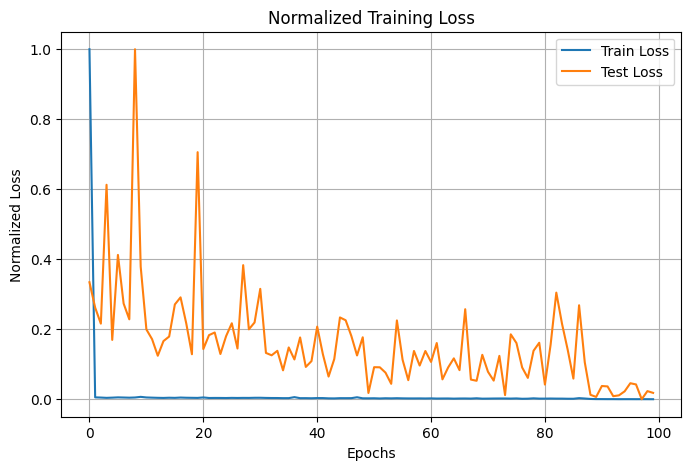

In [19]:
# Instantiate the model
model_4 = ReLUModel(input_size=input_len, output_size=output_len, hidden_units= 256)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 100,model = model_4, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

relu_model_256 = eval_model(model_4, test_loader, scaler_rev, device)

In [20]:
relu_model_256, relu_model

({'model_name': 'ReLUModel',
  'mean_distance_error_cm': 22.268592834472656,
  'std': 20.891780853271484},
 {'model_name': 'ReLUModel',
  'mean_distance_error_cm': 21.660932540893555,
  'std': 21.328611373901367})

#### ReLU 64

Τα αποτελέσματα με 128 hidden units είναι καλύτερα, δοκιμάζουμε τέλος με 64. **NOT**

Epoch 0 | Loss train: 3.9546147928788113 | Loss test: 0.9053975812026432 | lr = 0.01
Epoch 10 | Loss train: 0.3549120781513361 | Loss test: 0.3803009923015322 | lr = 0.01
Epoch 20 | Loss train: 0.26356160182219285 | Loss test: 0.36539635700838907 | lr = 0.01
Epoch 30 | Loss train: 0.2069944730744912 | Loss test: 0.44924991045679363 | lr = 0.01
Epoch 40 | Loss train: 0.2234735804108473 | Loss test: 0.3372307164328439 | lr = 0.01
Epoch 50 | Loss train: 0.11311673358655892 | Loss test: 0.30371270860944477 | lr = 0.001
Epoch 60 | Loss train: 0.09697454136151534 | Loss test: 0.29307310708931517 | lr = 0.001
Epoch 70 | Loss train: 0.0964054582783809 | Loss test: 0.30174127753291813 | lr = 0.001
Epoch 80 | Loss train: 0.08634316419752744 | Loss test: 0.3189765534230641 | lr = 0.001
Epoch 90 | Loss train: 0.08226751579115024 | Loss test: 0.32637667443071094 | lr = 0.001
Epoch 100 | Loss train: 0.07776035705151466 | Loss test: 0.31488481376852306 | lr = 0.001
Epoch 110 | Loss train: 0.070868762

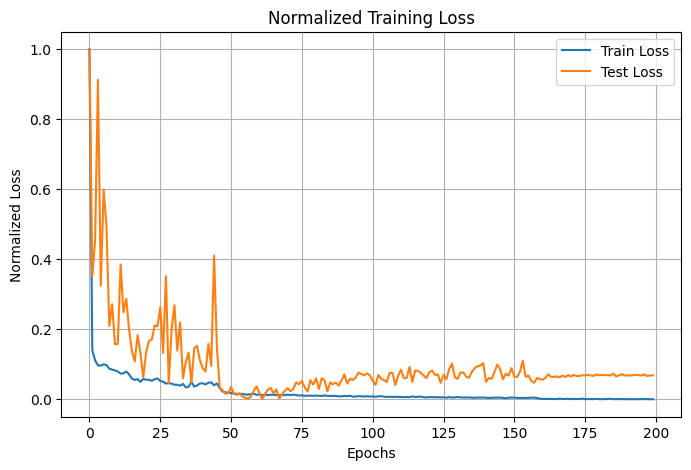

In [21]:
# Instantiate the model
model_5 = ReLUModel(input_size=input_len, output_size=output_len, hidden_units= 64)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_5.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 200,model = model_5, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

relu_model_64 = eval_model(model_5, test_loader, scaler_rev, device)

In [22]:
relu_model_256, relu_model_64, relu_model

({'model_name': 'ReLUModel',
  'mean_distance_error_cm': 22.268592834472656,
  'std': 20.891780853271484},
 {'model_name': 'ReLUModel',
  'mean_distance_error_cm': 17.894412994384766,
  'std': 19.376811981201172},
 {'model_name': 'ReLUModel',
  'mean_distance_error_cm': 21.660932540893555,
  'std': 21.328611373901367})

Η καλύτερη περίπτωση φαίνεται να είναι με 64 ```hidden_units```

***

### Αρχιτεκτονική 2.1

#### LeakyRELU

Για την συγκεκριμένη αρχιτεκτονική και τα συγκεκριμένα ```hidden_units``` θα μελετήσουμε την διαφορά που προκαλούν διάφορες συναρτήσεις ενεργοποίησης.

Αρχικά μελετάμε την LeakyReLU, με τύπο:

$LeakyReLU(x) = max(0,x) + negative\_slope * min(0,x)$

In [23]:
class LeakyReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 2.953534946991847 | Loss test: 1.5563423378126962 | lr = 0.01
Epoch 10 | Loss train: 0.4237137156037184 | Loss test: 0.459929142679487 | lr = 0.01
Epoch 20 | Loss train: 0.32583412069540757 | Loss test: 0.4974870639187949 | lr = 0.01
Epoch 30 | Loss train: 0.2485466221204171 | Loss test: 0.3920782761914389 | lr = 0.01
Epoch 40 | Loss train: 0.2574473266991285 | Loss test: 0.38689019424574717 | lr = 0.01
Epoch 50 | Loss train: 0.12580257210020834 | Loss test: 0.33227365570408957 | lr = 0.001
Epoch 60 | Loss train: 0.09689529039538823 | Loss test: 0.3231059472475733 | lr = 0.001
Epoch 70 | Loss train: 0.08255223012887515 | Loss test: 0.32322179845401217 | lr = 0.001
Epoch 80 | Loss train: 0.06530490689552747 | Loss test: 0.33581152664763586 | lr = 0.001
Epoch 90 | Loss train: 0.057028394049176805 | Loss test: 0.3816345440489905 | lr = 0.001
Epoch 100 | Loss train: 0.05169706103893427 | Loss test: 0.35938465488808496 | lr = 0.001
Epoch 110 | Loss train: 0.04726579624

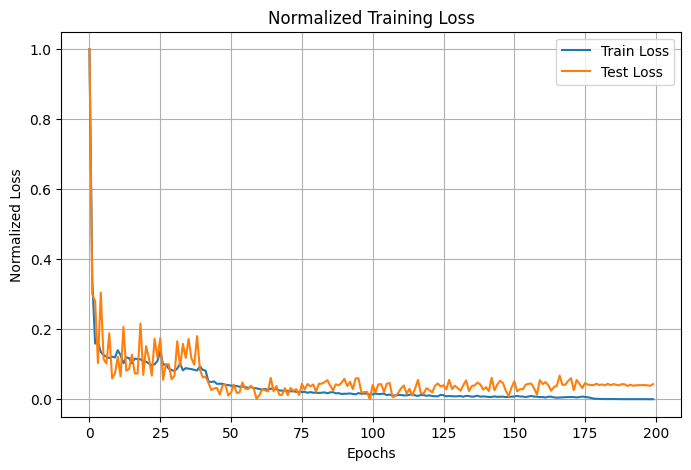

In [24]:
# Instantiate the model
model_6 = LeakyReLUModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_6.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_6, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

leakyrelu = eval_model(model_6, test_loader, scaler_rev, device)

In [25]:
leakyrelu

{'model_name': 'LeakyReLUModel',
 'mean_distance_error_cm': 17.475900650024414,
 'std': 19.26310920715332}

#### Tanh

Δοκιμάζουμε την συνάρτηση ενεργοποίησης tanh. 

$tanh(x) = \frac{exp(x) - exp(-x)}{exp(x) + exp(-x)}$

In [26]:
class tanhModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(tanhModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 0.6705215607698147 | Loss test: 0.6990099847316742 | lr = 0.01
Epoch 10 | Loss train: 0.4218261241912842 | Loss test: 0.5765420794487 | lr = 0.01
Epoch 20 | Loss train: 0.40379146429208607 | Loss test: 0.6011338915143695 | lr = 0.01
Epoch 30 | Loss train: 0.3759213708914243 | Loss test: 0.640789304460798 | lr = 0.01
Epoch 40 | Loss train: 0.38875629752874374 | Loss test: 0.5387914521353585 | lr = 0.001
Epoch 50 | Loss train: 0.2486048165995341 | Loss test: 0.48876803687640596 | lr = 0.001
Epoch 60 | Loss train: 0.23158912188731706 | Loss test: 0.496752211025783 | lr = 0.001
Epoch 70 | Loss train: 0.20480324901067293 | Loss test: 0.5114723145961761 | lr = 0.001
Epoch 80 | Loss train: 0.1979126397233743 | Loss test: 0.5153933252607074 | lr = 0.001
Epoch 90 | Loss train: 0.18844445479603913 | Loss test: 0.5118126422166824 | lr = 0.001
Epoch 100 | Loss train: 0.1748605605501395 | Loss test: 0.52310810983181 | lr = 0.001
Epoch 110 | Loss train: 0.17026101081417158 | Lo

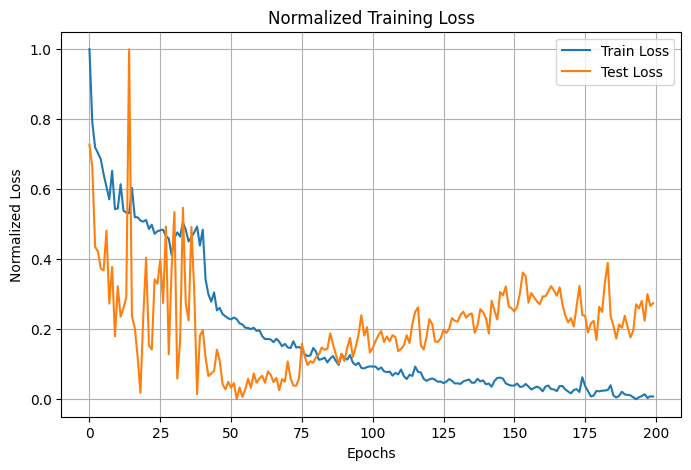

In [27]:
# Instantiate the model
model_8 = tanhModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_8.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_8, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

tanh_model = eval_model(model_8, test_loader, scaler_rev, device)

#### Sigmoid

$Sigmoid(x) = \frac{1}{1+exp(-x)}$

In [28]:
class sigmoidModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(sigmoidModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 0.6905051721976354 | Loss test: 0.6555543967655727 | lr = 0.01
Epoch 10 | Loss train: 0.4189860184605305 | Loss test: 0.5617922416755131 | lr = 0.01
Epoch 20 | Loss train: 0.37182195255389583 | Loss test: 0.5053938393081937 | lr = 0.01
Epoch 30 | Loss train: 0.3539591832802846 | Loss test: 0.47217303940228056 | lr = 0.01
Epoch 40 | Loss train: 0.29671999267660654 | Loss test: 0.5064171254634857 | lr = 0.01
Epoch 50 | Loss train: 0.29572266798753005 | Loss test: 0.4689329905169351 | lr = 0.01
Epoch 60 | Loss train: 0.2658103907910677 | Loss test: 0.49920132756233215 | lr = 0.001
Epoch 70 | Loss train: 0.24292586686519477 | Loss test: 0.4886338072163718 | lr = 0.001
Epoch 80 | Loss train: 0.23020802380946967 | Loss test: 0.48860993129866465 | lr = 0.001
Epoch 90 | Loss train: 0.21857172680588868 | Loss test: 0.48281080382210867 | lr = 0.001
Epoch 100 | Loss train: 0.21205913361448508 | Loss test: 0.4823801560061319 | lr = 0.001
Epoch 110 | Loss train: 0.210324144993

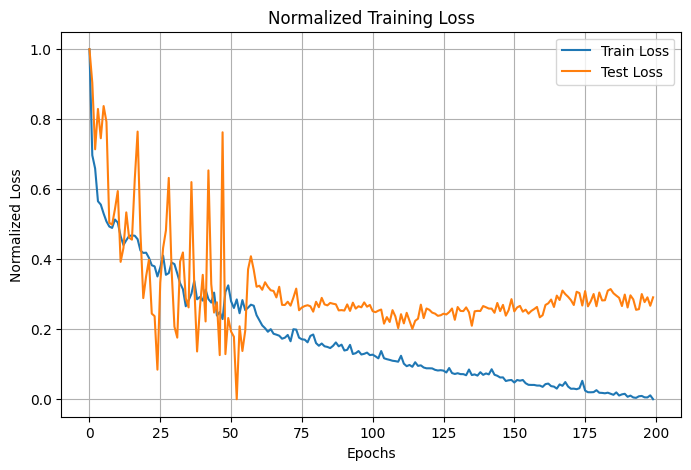

In [29]:
# Instantiate the model
model_9 = sigmoidModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_9.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_9, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

sigmoid_model = eval_model(model_9, test_loader, scaler_rev, device)

### Αρχιτεκτονική 3

#### +1 Layer

Μιας και βλέπουμε ότι τα καλύτερα αποτελέσματα τα δίνει το μοντέλο με συνάρτηση ενεργοποίησης LeakyReLU , θα δοκιμάσουμε να βάλουμε άλλο ένα layer για να δούμε πως θα επηρεαστουν τα αποτελέσματα.

In [30]:
class LeakyReLUModel4(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel4, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 1.5904019899093187 | Loss test: 0.5920493347304208 | lr = 0.01
Epoch 10 | Loss train: 0.34310470406825727 | Loss test: 0.38563707045146395 | lr = 0.01
Epoch 20 | Loss train: 0.2559521086513996 | Loss test: 0.33321806149823324 | lr = 0.01
Epoch 30 | Loss train: 0.2192079138297301 | Loss test: 0.3438285312482289 | lr = 0.01
Epoch 40 | Loss train: 0.19415163735930735 | Loss test: 0.4384754512991224 | lr = 0.01
Epoch 50 | Loss train: 0.10933655471755908 | Loss test: 0.32258763164281845 | lr = 0.001
Epoch 60 | Loss train: 0.09051042436980285 | Loss test: 0.329974254327161 | lr = 0.001
Epoch 70 | Loss train: 0.08114826449981102 | Loss test: 0.33971533605030607 | lr = 0.001
Epoch 80 | Loss train: 0.0710963338900071 | Loss test: 0.3461571452873094 | lr = 0.001
Epoch 90 | Loss train: 0.06047127718249193 | Loss test: 0.3724206175122942 | lr = 0.001
Epoch 100 | Loss train: 0.05032778216096071 | Loss test: 0.34923437397394863 | lr = 0.001
Epoch 110 | Loss train: 0.04405310664

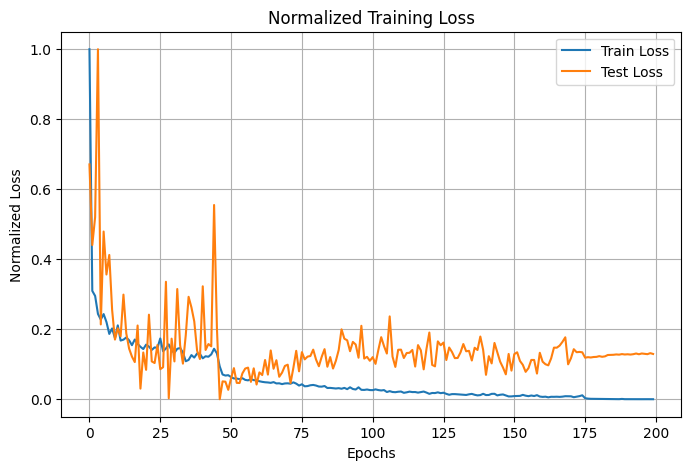

In [31]:
# Instantiate the model
model_10 = LeakyReLUModel4(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_10.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_10, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

leakyrelu_4 = eval_model(model_10, test_loader, scaler_rev, device)

Παρατηρούμε ότι η επίδοση του μοντέλου δεν καλυτέρεψε, άρα δεν χρειάζεται να προσθέσουμε και άλλα layers.

#### -1 Layer

In [32]:
class LeakyReLUModel2(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel2, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 54.48631504178047 | Loss test: 9.74035222189767 | lr = 0.01
Epoch 10 | Loss train: 0.5000041494002709 | Loss test: 0.6213522042546954 | lr = 0.01
Epoch 20 | Loss train: 0.4533973101239938 | Loss test: 0.7234734467097691 | lr = 0.01
Epoch 30 | Loss train: 0.4163736351407491 | Loss test: 0.49083892362458365 | lr = 0.01
Epoch 40 | Loss train: 0.40642324548501235 | Loss test: 0.6709643091474261 | lr = 0.01
Epoch 50 | Loss train: 0.48946535415374315 | Loss test: 0.697943206344332 | lr = 0.01
Epoch 60 | Loss train: 0.3759309809941512 | Loss test: 0.5541408785751888 | lr = 0.001
Epoch 70 | Loss train: 0.15563181873697501 | Loss test: 0.38378901353904177 | lr = 0.001
Epoch 80 | Loss train: 0.14229201568433872 | Loss test: 0.3662618228367397 | lr = 0.001
Epoch 90 | Loss train: 0.13193200542949712 | Loss test: 0.40493289700576235 | lr = 0.001
Epoch 100 | Loss train: 0.1251442819260634 | Loss test: 0.4470628340329443 | lr = 0.001
Epoch 110 | Loss train: 0.11527126483046092 |

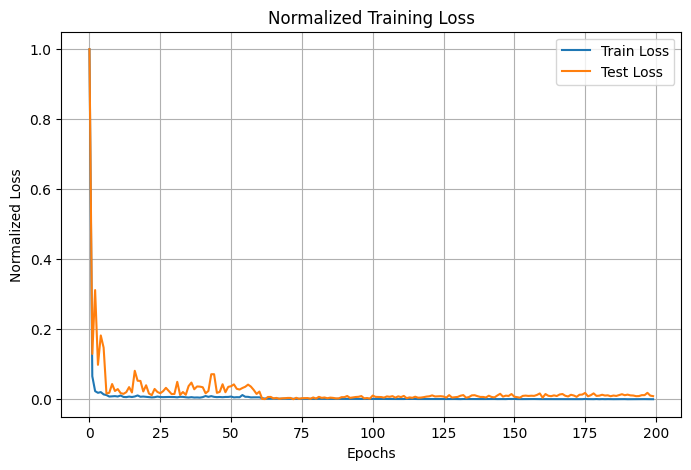

In [34]:
# Instantiate the model
model_14 = LeakyReLUModel2(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_14.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20)

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_14, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

leakyrelu_2 = eval_model(model_14, test_loader, scaler_rev, device)

#### -1 Layer rmsprop

In [35]:
class LeakyReLUModel2(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel2, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 5495.179742677854 | Loss test: 390.4043666294643 | lr = 0.01
Epoch 10 | Loss train: 3.817005869287711 | Loss test: 3.3765334401811873 | lr = 0.01
Epoch 20 | Loss train: 3.375322062235612 | Loss test: 5.901046173913138 | lr = 0.01
Epoch 30 | Loss train: 1.1129997255137334 | Loss test: 0.46608290502003263 | lr = 0.001
Epoch 40 | Loss train: 0.22062813146756247 | Loss test: 0.3770563304424286 | lr = 0.001
Epoch 50 | Loss train: 0.18935909322821176 | Loss test: 0.4040102405207498 | lr = 0.001
Epoch 60 | Loss train: 0.18193711483707795 | Loss test: 0.33750186754124506 | lr = 0.001
Epoch 70 | Loss train: 0.16758051715218103 | Loss test: 0.5802560022899083 | lr = 0.001
Epoch 80 | Loss train: 0.1726561804803518 | Loss test: 0.3367453898702349 | lr = 0.001
Epoch 90 | Loss train: 0.14619358385411593 | Loss test: 0.3797202855348587 | lr = 0.001
Epoch 100 | Loss train: 0.1394344654220801 | Loss test: 0.4148900498236929 | lr = 0.001
Epoch 110 | Loss train: 0.14195954599059546 

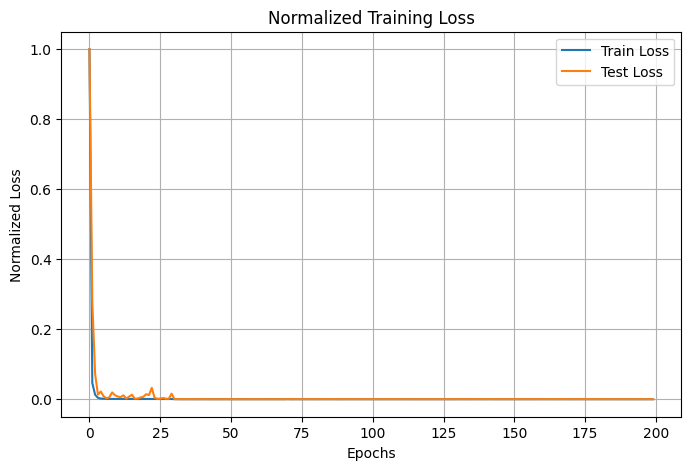

In [36]:
# Instantiate the model
model_15 = LeakyReLUModel2(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(model_15.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_15, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

leakyrelu_2_rms = eval_model(model_15, test_loader, scaler_rev, device)

### Αρχιτεκτονική 4

#### Dropout

Θα προσθέσουμε ένα άλλο επίπεδο που συνίσταται σε μοντέλα με μικρά datasets, το ```Dropout```. Αυτό, με πιθανότητα p "νεκρώνει" έναν νευρώνα, βοηθώντας έτσι το μοντέλο να κατανοήσει γενικότερα συμπεράσματα για τα δεδομένα που του δίνουμε.

In [37]:
class LeakyReLUModelDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModelDropout, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 4.927274701687006 | Loss test: 0.7960347618375506 | lr = 0.01
Epoch 10 | Loss train: 0.5504769367667345 | Loss test: 0.6173212570803506 | lr = 0.01
Epoch 20 | Loss train: 0.41734588891267776 | Loss test: 0.4081574082374573 | lr = 0.01
Epoch 30 | Loss train: 0.25399533143410313 | Loss test: 0.3393990674189159 | lr = 0.001
Epoch 40 | Loss train: 0.22533464460418776 | Loss test: 0.3090518042445183 | lr = 0.001
Epoch 50 | Loss train: 0.1981524627369184 | Loss test: 0.28561839780637194 | lr = 0.001
Epoch 60 | Loss train: 0.17996756445903045 | Loss test: 0.29453395839248386 | lr = 0.001
Epoch 70 | Loss train: 0.1906088894376388 | Loss test: 0.30581450036593844 | lr = 0.001
Epoch 80 | Loss train: 0.1622706697537349 | Loss test: 0.27337605293307987 | lr = 0.0001
Epoch 90 | Loss train: 0.1398885831809961 | Loss test: 0.27842787546770914 | lr = 0.0001
Epoch 100 | Loss train: 0.15205428319481704 | Loss test: 0.2755009170089449 | lr = 0.0001
Epoch 110 | Loss train: 0.14315739

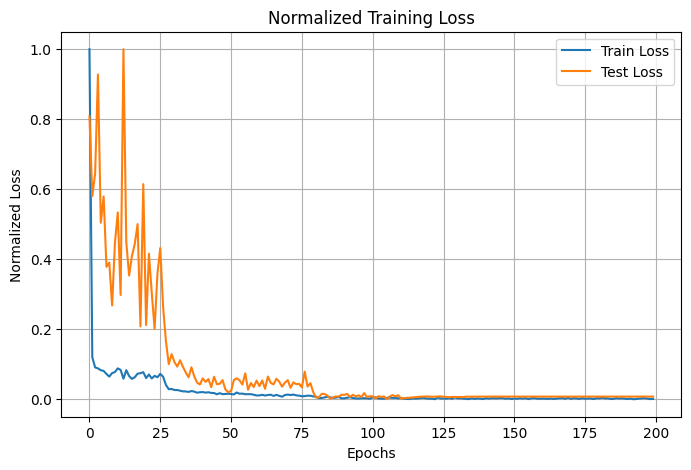

In [38]:
# Instantiate the model
model_11 = LeakyReLUModelDropout(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_11.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_11, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

dropout_model = eval_model(model_11, test_loader, scaler_rev, device)

### Αρχιτεκτονική 5

#### XGB

Θα χρησιμοποιήσουμε και τον γνωστό αλγόριθμο για regression XGB, με την βοήθεια του MultiOutputRegressor.

In [39]:
X = info_tensor.reshape(len(info_tensor), -1)
y = rfid_label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler_Y = StandardScaler()
# Also scale the Y input since when we use MSE loss and the labels are in CM, MSE will scale quadratically with those values
y_train = scaler_Y.fit_transform(y_train)
y_test = scaler_Y.transform(y_test)


In [40]:
xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=1500, learning_rate=0.01, eta = 0.2, tree_method = 'hist', device = 'cuda')

# Fit the model
multi_xgb = MultiOutputRegressor(xgb_model)
multi_xgb.fit(X_train_scaled, y_train) 

# Predict the model
y_pred = multi_xgb.predict(X_test_scaled)

# Reverse scaling
y_pred_real = scaler_Y.inverse_transform(y_pred)
y_true_real = scaler_Y.inverse_transform(y_test)

xgb_loss = np.mean(np.linalg.norm(y_pred_real - y_true_real, axis=1))
xgb_var = np.std(np.linalg.norm(y_pred_real - y_true_real, axis=1))
xgb_res = {'model_name': 'xgb_model', 'mean_distance_error_cm' : xgb_loss, 'std': xgb_var}

c:\Users\jimka\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:33:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


### Αρχιτεκτονική 6

#### Epochs

Θα δοκιμάσουμε επίσης αντί να δημιουργούμε batches να περνάμε τα data απευθείας στο μοντέλο.

Για την δοκιμή αυτή θα χρησιμοποιήσουμε το μοντέλο LeakyReLUModel4 με συνάρτηση ενεργοποίησης την LeakyReLU και 4 επίπεδα.

Δεν δημιουργώ συναρτήσεις αφού είναι μεμονομένη περίπτωση.

In [41]:
# Instantiate the model
model_13 = LeakyReLUModel4(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_13.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [42]:
X = info_tensor.reshape(len(info_tensor), -1)
y = rfid_label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler_Y = StandardScaler()
# Also scale the Y input since when we use MSE loss and the labels are in CM, MSE will scale quadratically with those values
y_train = scaler_Y.fit_transform(y_train)
y_test = scaler_Y.transform(y_test)


In [43]:
# Set seed before defining model and optimizer
torch.manual_seed(42)  

# Move model to device **before** training
model_13.to(device)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

# Set number of epochs
epochs = 1000  

# Training loop
for epoch in range(epochs):
    model_13.train()
    
    # Forward pass
    y_pred = model_13(X_train_tensor)

    # Compute loss
    loss = loss_fn(y_pred, y_train_tensor)  

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    model_13.eval()
    with torch.inference_mode():
        test_logits = model_13(X_test_tensor)
        test_loss = loss_fn(test_logits, y_test_tensor).detach()  # Ensure no gradients


    # Update learning rate scheduler
    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(test_loss.detach())  
    else:
        scheduler.step()

    # Print every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")
print(f"Epoch: {epoch + 1} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")


model_13.eval()
with torch.inference_mode():
    y_pred = model_13(X_test_tensor)
# Reverse scaling
y_pred_real = scaler_Y.inverse_transform(y_pred.cpu())
y_true_real = scaler_Y.inverse_transform(y_test_tensor.cpu())

distances = np.linalg.norm(y_pred_real - y_true_real, axis=1)
mean_distance_error = np.mean(distances)
std = np.std(distances)

epoch_res = {'model_name': 'LeakyReLU4_noBatches', 'mean_distance_error_cm' : mean_distance_error.item(), 'std': std.item()}

Epoch: 0 | Train Loss: 1.00714 | Test Loss: 2.33689
Epoch: 100 | Train Loss: 0.19401 | Test Loss: 0.37669
Epoch: 200 | Train Loss: 0.14146 | Test Loss: 0.35487
Epoch: 300 | Train Loss: 0.12855 | Test Loss: 0.35547
Epoch: 400 | Train Loss: 0.12855 | Test Loss: 0.35547
Epoch: 500 | Train Loss: 0.12855 | Test Loss: 0.35547
Epoch: 600 | Train Loss: 0.12855 | Test Loss: 0.35547
Epoch: 700 | Train Loss: 0.12855 | Test Loss: 0.35547
Epoch: 800 | Train Loss: 0.12855 | Test Loss: 0.35547
Epoch: 900 | Train Loss: 0.12855 | Test Loss: 0.35547
Epoch: 1000 | Train Loss: 0.12855 | Test Loss: 0.35547


## Results

In [44]:
compare_results = pd.DataFrame([leakyrelu, leakyrelu_4, leakyrelu_2,leakyrelu_2_rms, relu_model,dropout_model, sigmoid_model, tanh_model])
compare_results = compare_results._append(xgb_res, ignore_index = True)
compare_results = compare_results._append(epoch_res, ignore_index = True)
compare_results.sort_values(by = 'mean_distance_error_cm', ascending= True, inplace= True)

compare_results

,model_name,mean_distance_error_cm,std
5,LeakyReLUModelDropout,16.639196,18.421173
0,LeakyReLUModel,17.475901,19.263109
8,xgb_model,18.068656,16.809581
1,LeakyReLUModel4,18.213758,19.185244
9,LeakyReLU4_noBatches,19.433358,20.748325
3,LeakyReLUModel2,19.962599,21.084923
4,ReLUModel,21.660933,21.328611
2,LeakyReLUModel2,21.759197,22.490553
6,sigmoidModel,26.535666,25.934759
7,tanhModel,28.865471,24.096045


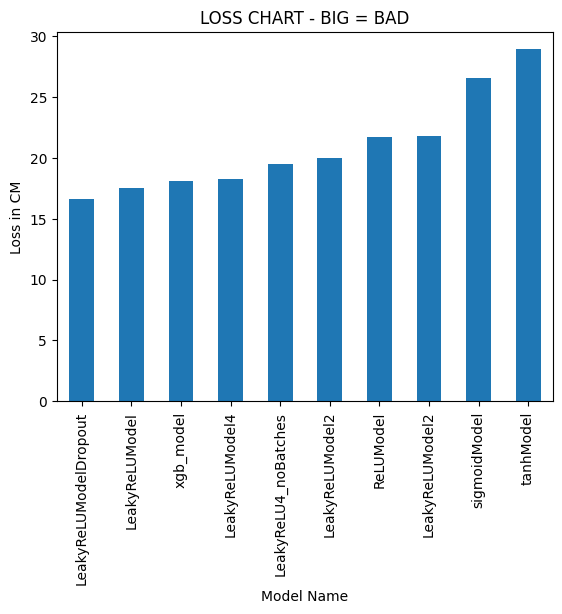

In [45]:
# Visualize our model results
compare_results.set_index("model_name")["mean_distance_error_cm"].plot(kind="bar")
plt.xlabel("Model Name")
plt.ylabel("Loss in CM")
plt.title("LOSS CHART - BIG = BAD")
plt.show()

***